In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
two_composite_filtered = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)

In [4]:
variable = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
#covariates = ['Sulph1_Code', 'Sulph1_Pct']


#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', variable] + covariates
two_composite_1covariates = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1covariates = two_composite_1covariates.dropna(subset=[variable] + covariates)


In [5]:
len(two_composite_1covariates['Density_gcm3'])

2618

In [6]:

encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])



In [7]:
# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

In [8]:
# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [9]:
#Activate this cell to use dummies for the sulphides
#total_columns = encoded_data[['Sulph2_Code_PO','Sulph1_Code_CP', 'Sulph2_Code_CP']].columns.tolist()


In [10]:
deposit_data = encoded_data[["Name","X", "Y", "Z", "Density_gcm3"] + total_columns]
covariates = total_columns[:3]

In [11]:
np.random.seed(42)


#variable = 'Density_gcm3'
#two_composite_1variable = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', variable]]
#deposit_data = two_composite_1variable.dropna(subset=[variable])
    
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
deposit_data.loc[:, [variable]] = scaler.fit_transform(deposit_data.loc[:, [variable]])

x = deposit_data[['X', 'Y', 'Z']].values  # Use X, Y, and Z coordinates
y = deposit_data[variable].values[:, np.newaxis]  # Keep variable as the output
x = x.reshape(len(deposit_data), 3)

C:\Users\23478671\AppData\Local\Temp\ipykernel_4984\3880134271.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_4984\3880134271.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_4984\3880134271.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [12]:
deposit_data

,Name,X,Y,Z,Density_gcm3,CP_Total,PO_Total,PY_Total,SU_Total,PE_Total
393,KV-NME001,0.437814,0.509816,0.461455,0.400922,1.0,1.0,0.0,0.0,0.0
394,KV-NME001,0.438061,0.509789,0.460591,0.410138,1.0,1.0,0.0,0.0,0.0
434,KV-NME001,0.448174,0.508800,0.426068,0.442396,1.0,1.0,0.0,0.0,0.0
435,KV-NME001,0.448431,0.508777,0.425204,0.442396,1.5,2.0,0.0,0.0,0.0
436,KV-NME001,0.448683,0.508755,0.424340,0.442396,2.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,0.629186,0.001755,0.432766,0.543779,0.2,3.0,0.0,0.0,0.0
81072,KV365,0.629096,0.001314,0.431988,0.539171,0.2,3.0,0.0,0.0,0.0
81073,KV365,0.629011,0.000877,0.431205,0.543779,0.2,3.0,0.0,0.0,0.0
81074,KV365,0.628921,0.000436,0.430427,0.525346,0.2,3.0,0.0,0.0,0.0


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pykrige.ok import OrdinaryKriging
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Generate dummy data
# np.random.seed(42)
# n_samples = 100
# x = np.random.rand(n_samples, 2)  # Two-dimensional input features
# y = 3 * X[:, 0] + 5 * X[:, 1] + np.random.normal(scale=0.1, size=n_samples)  # Linear relationship with noise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Ordinary Kriging on residuals
ok = OrdinaryKriging(X_test[:, 0], X_test[:, 1], y_test, variogram_model='linear', verbose=False)
kriging_pred, kriging_std = ok.execute('grid', X_test[:, 0], X_test[:, 1])

# Use Kriging predictions directly
final_predictions = kriging_pred



mse = np.mean((y_test - final_predictions) ** 2)
mae = np.mean(np.abs(y_test - final_predictions))
sst = np.mean((y_test - np.mean(y_test)) ** 2)*len(x)
ssr = np.mean((y_test - final_predictions) ** 2)*len(x)
r2 = 1 - (ssr / sst)

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")



Mean Squared Error (MSE): 0.012659637238725109
Mean Absolute Error (MAE): 0.07110084069696973
R-squared (R2): 0.13125064220540938


In [14]:
len(x)

2618

In [16]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

mse_list, mae_list, r2_list = [], [], []
for train_index, test_index in kf.split(x):
    X_cv_train, X_cv_test = x[train_index], x[test_index]
    y_cv_train, y_cv_test = y[train_index], y[test_index]

    # Fit a linear regression model
    regression_model = LinearRegression()
    regression_model.fit(X_cv_train, y_cv_train)

    # Predictions from the regression model
    y_cv_pred = regression_model.predict(X_cv_test)

    # Residuals (the difference between actual and predicted values)
    residuals = y_cv_test - y_cv_pred

    # Ordinary Kriging on residuals
    ok = OrdinaryKriging(X_cv_test[:, 0], X_cv_test[:, 1], y_cv_test, variogram_model='linear', verbose=False)
    kriging_pred, _ = ok.execute('grid', X_cv_test[:, 0], X_cv_test[:, 1])


    # Use Kriging predictions directly
    final_predictions = kriging_pred

    # Combine regression predictions with kriging predictions
    #final_cv_predictions = y_cv_pred + kriging_pred
    final_cv_predictions =  kriging_pred

    # Calculate and store metrics
    mse = np.mean((y_cv_test - final_cv_predictions) ** 2)
    mae = np.mean(np.abs(y_cv_test - final_cv_predictions))
    sst = np.mean((y_cv_test - np.mean(y_cv_test)) ** 2)*len(y_cv_test)
    ssr = np.mean((final_cv_predictions - y_cv_test) ** 2)*len(y_cv_test)
    r2 = 1 - (ssr / sst)


    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Calculate mean metrics across folds
mean_mse = np.mean(mse_list)
mean_mae = np.mean(mae_list)
mean_r2 = np.mean(r2_list)

# Print mean metrics
print(f"Mean Squared Error (MSE): {mean_mse}")
print(f"Mean Absolute Error (MAE): {mean_mae}")
print(f"Mean R-squared (R2): {mean_r2}")

Mean Squared Error (MSE): 0.01436728406088461
Mean Absolute Error (MAE): 0.07749732186153649
Mean R-squared (R2): 0.09205351299406729


In [ ]:
combined_rmse = np.sqrt(np.mean((y_test - final_predictions)**2))
print(f"Combined RMSE: {combined_rmse}")

Combined RMSE: 0.08026864829138865


In [ ]:
np.mean(y_test - final_predictions)

4.804913590422677e-07

In [ ]:
kriging_pred

masked_array(
  data=[[0.3959970262180951, -0.006370223417187956,
         -0.0063702234182493244, ..., -0.006370223418480892,
         -0.006370223418192169, -0.006370223418193365],
        [-0.006370223418013787, 0.009152998876017225,
         -0.0063702234167984555, ..., -0.00637022341879996,
         -0.006370223416895931, -0.006370223416894924],
        [-0.006370223421567374, -0.006370223421895292,
         0.03512821025005801, ..., -0.006370223420586196,
         -0.006370223423631065, -0.006370223423636636],
        ...,
        [-0.006370223418070305, -0.006370223417903206,
         -0.006370223416910928, ..., -0.08434859219059901,
         -0.006370223417144732, -0.006370223417142459],
        [-0.006370223418001135, -0.006370223417748764,
         -0.006370223416774973, ..., -0.006370223418812491,
         0.07339410493300806, -0.0063702234168713035],
        [-0.006370223421565856, -0.006370223421896199,
         -0.006370223424069899, ..., -0.006370223420585353,
         -

In [ ]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")


## Cross validation

Fold 1:
Training MSE: 0.0081, Test MSE: 0.0081
Fold 2:
Training MSE: 0.0116, Test MSE: 0.0096
Fold 3:
Training MSE: 0.0101, Test MSE: 0.0108
Fold 4:
Training MSE: 0.0128, Test MSE: 0.0130
Fold 5:
Training MSE: 0.0092, Test MSE: 0.0114
Cross-validation results:
Mean Training MSE = 0.0103, Std. Dev. Training MSE = 0.0017
Mean Test MSE = 0.0106, Std. Dev. Test MSE = 0.0016


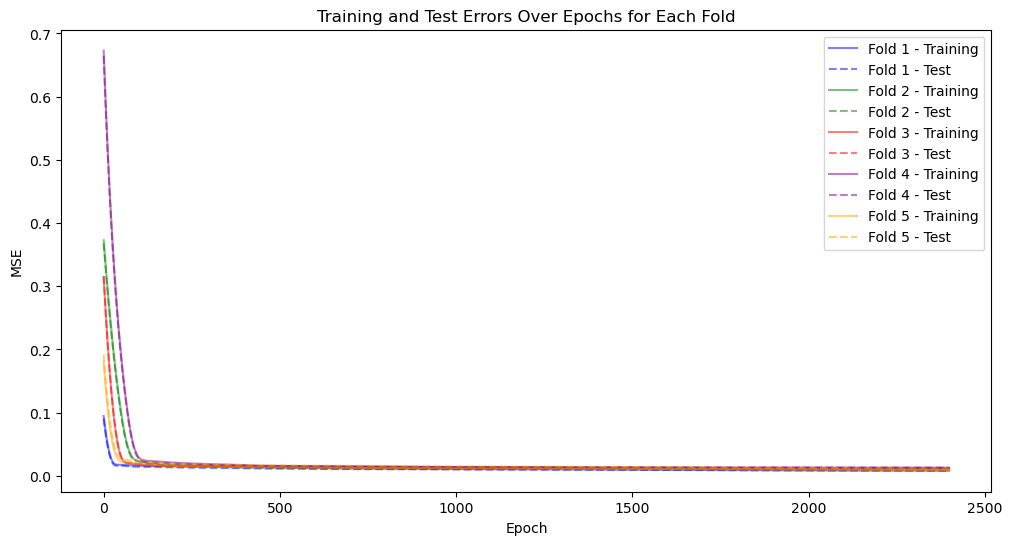

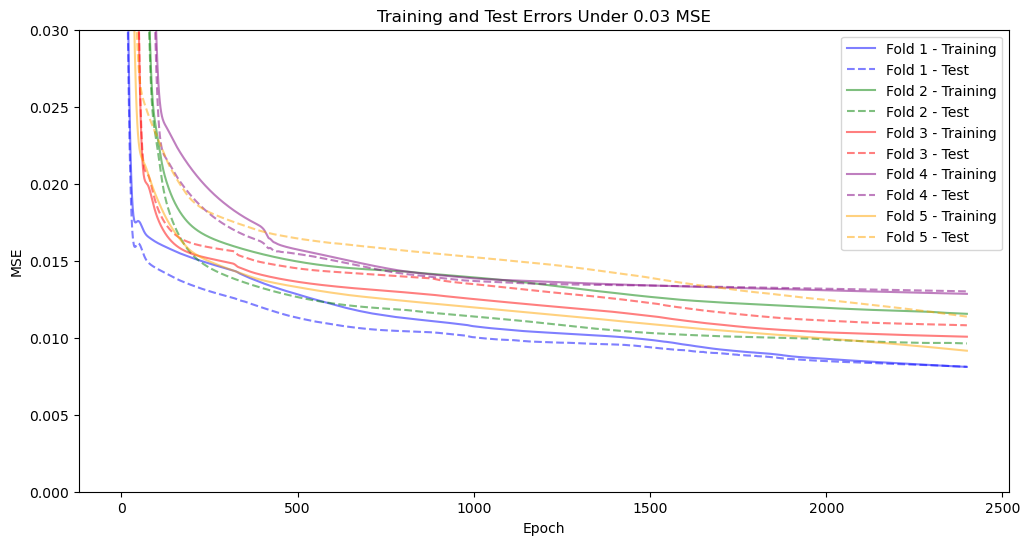

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


deposit_data.loc[:, [variable]+covariates] = scaler.fit_transform(deposit_data.loc[:,[variable]+covariates])


deposit_data=deposit_data.sort_values(by='Z')

x = deposit_data[['X','Y', 'Z'] + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),3+len(covariates))
x = x[:,[i for i in range(3+len(covariates))]]





x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# # Iterate through unique 'Name' values and assign each hole's data to either train or test
# for name in unique_names:
#     # Select data for the current hole
#     hole_data = deposit_data[deposit_data['Name'] == name]
#     x_hole = hole_data[['X', 'Y', 'Z'] + covariates].values
#     y_hole = hole_data['Density_gcm3'].values

#     # Assign the hole's data to either train or test
#     if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
#         x_test.extend(x_hole)
#         y_test.extend(y_hole)
#     else:
#         x_train.extend(x_hole)
#         y_train.extend(y_hole)

# # Convert the lists to NumPy arrays
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

# x_train = torch.tensor(x_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# x_test = torch.tensor(x_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)





n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)








# Define a list of colors for each fold
colors = ['blue', 'green', 'red', 'purple', 'orange']

mse_train_values = []  # To store training MSE for each fold
mse_test_values = []   # To store test MSE for each fold

for i, (train_indices, val_indices) in enumerate(kf.split(x)):
    x_train_fold = x[train_indices]
    y_train_fold = y[train_indices]
    x_val_fold = x[val_indices]
    y_val_fold = y[val_indices]

    inp_features = 3+len(covariates)
    model = nn.Sequential(
        nn.Linear(in_features=inp_features, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    for step in range(2400):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold.reshape(-1, 1))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Evaluate the model on the training set
        pre_train = model(x_train_fold)
        mse_train = mse_loss(pre_train, y_train_fold.reshape(-1, 1))
        train_losses.append(mse_train.item())

        # Evaluate the model on the validation set
        pre_val = model(x_val_fold)
        mse_val = mse_loss(pre_val, y_val_fold.reshape(-1, 1))
        test_losses.append(mse_val.item())

    mse_train_values.append(train_losses)
    mse_test_values.append(test_losses)

    print(f'Fold {i + 1}:')
    print(f'Training MSE: {mse_train.item():.4f}, Test MSE: {mse_val.item():.4f}')

    

# Calculate the mean and standard deviation of training and test MSE values across folds
mean_train_mse = np.mean(mse_train_values, axis=0)
std_train_mse = np.std(mse_train_values, axis=0)
mean_test_mse = np.mean(mse_test_values, axis=0)
std_test_mse = np.std(mse_test_values, axis=0)

print(f'Cross-validation results:')
print(f'Mean Training MSE = {mean_train_mse[-1]:.4f}, Std. Dev. Training MSE = {std_train_mse[-1]:.4f}')
print(f'Mean Test MSE = {mean_test_mse[-1]:.4f}, Std. Dev. Test MSE = {std_test_mse[-1]:.4f}')



# Create a plot of training and test errors for each fold in the same plot
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test Errors Over Epochs for Each Fold')

# Create a plot showing only values lower than 0.03 on the y-axis
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.03)  # Set the y-axis limit to filter values under 0.03
plt.legend()
plt.title('Training and Test Errors Under 0.03 MSE')
plt.show()


In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# torch.manual_seed(42)
# np.random.seed(42)

# # Extract unique 'Name' values
# unique_names = deposit_data['Name'].unique()

# # Create an array to store metrics for each fold
# test_mse_list = []
# test_rmse_list = []
# test_mae_list = []
# test_r2_list = []

# # Define the number of folds for cross-validation
# num_folds = 10
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Perform k-fold cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(unique_names)):
#     train_names, test_names = unique_names[train_index], unique_names[test_index]

#     # Filter data based on selected train and test names
#     train_data = deposit_data[deposit_data['Name'].isin(train_names)]
#     test_data = deposit_data[deposit_data['Name'].isin(test_names)]

#     x_train = train_data[['X', 'Y', 'Z'] + covariates].values
#     y_train = train_data['Density_gcm3'].values

#     x_test = test_data[['X', 'Y', 'Z'] + covariates].values
#     y_test = test_data['Density_gcm3'].values


#     # Define your neural network
#     model = nn.Sequential(
#         nn.Linear(in_features=6, out_features=500),
#         nn.ReLU(),
#         nn.Linear(in_features=500, out_features=1)
#     )

#     mse_loss = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     train_losses = []  # To store training losses during training
#     test_losses = []   # To store test losses during training

#     # Training loop
#     for step in range(81):
#         pre = model(torch.tensor(x_train, dtype=torch.float32))
#         mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
#         cost = mse

#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()

#         pre_test = model(torch.tensor(x_test, dtype=torch.float32))
#         mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
#         test_losses.append(mse_test.item())

#     # Store metrics for this fold
#     test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
#     test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
#     test_rmse_list.append(np.sqrt(test_mse_list[-1]))
#     test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
#     test_r2_list.append(r2_score(y_test, test_predictions_fold))

#     # Print metrics for the current fold
#     print(f"\nMetrics for Fold {fold + 1}:")
#     print_metrics(y_test, test_predictions_fold, "Test")

# # Print average metrics across folds
# print("\nAverage Metrics Across Folds:")
# print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
# print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
# print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
# print(f"  Average R^2: {np.mean(test_r2_list):.4f}")





In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[['X', 'Y', 'Z'] + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z'] + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=6, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(2400):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD R^2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0086
  RMSE: 0.0926
  MAE: 0.0625
  R^2: 0.4894


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0095
  RMSE: 0.0973
  MAE: 0.0657
  R^2: 0.1528


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0093
  RMSE: 0.0966
  MAE: 0.0629
  R^2: 0.4186


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0098
  RMSE: 0.0991
  MAE: 0.0678
  R^2: 0.1492


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0129
  RMSE: 0.1135
  MAE: 0.0745
  R^2: 0.2901


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0108
  RMSE: 0.1040
  MAE: 0.0711
  R^2: 0.2689


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0099
  RMSE: 0.0996
  MAE: 0.0682
  R^2: 0.2072


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0092
  RMSE: 0.0960
  MAE: 0.0624
  R^2: 0.4894


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0123
  RMSE: 0.1107
  MAE: 0.0729
  R^2: 0.3974


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0142
  RMSE: 0.1192
  MAE: 0.0796
  R^

In [ ]:
import torch
import numpy as np

# Assuming `model` is your trained neural network
model.eval()

# Initialize an array to accumulate gradients for each feature
total_gradients = np.zeros_like(x_train[0], dtype=float)

# Iterate over all instances to accumulate gradients
for instance_index in range(len(x_train)):
    selected_instance = torch.tensor(x_train[instance_index], dtype=torch.float32).unsqueeze(0)  # Add a batch dimension
    selected_instance.requires_grad_(True)
    
    # Forward pass
    output = model(selected_instance)

    # Backward pass to compute gradients
    model.zero_grad()
    output.backward()

    # Accumulate gradients for each feature
    total_gradients += selected_instance.grad.detach().numpy()[0]

# Calculate feature importance as the absolute mean of gradients across instances
average_importance = np.abs(total_gradients / len(x_train))

# Print or use the average_importance as needed
print("Average Feature Importance:", average_importance)


Average Feature Importance: [0.14337136 0.21984006 0.12295341 0.1925178  0.11240276 0.06410833]


## Train and test samples completely random

- Iteration 0, MSE: 0.110


C:\Users\23478671\AppData\Local\Temp\ipykernel_18728\3902631180.py:59: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_18728\3902631180.py:60: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_18728\3902631180.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_18728\3902631180.py:62: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

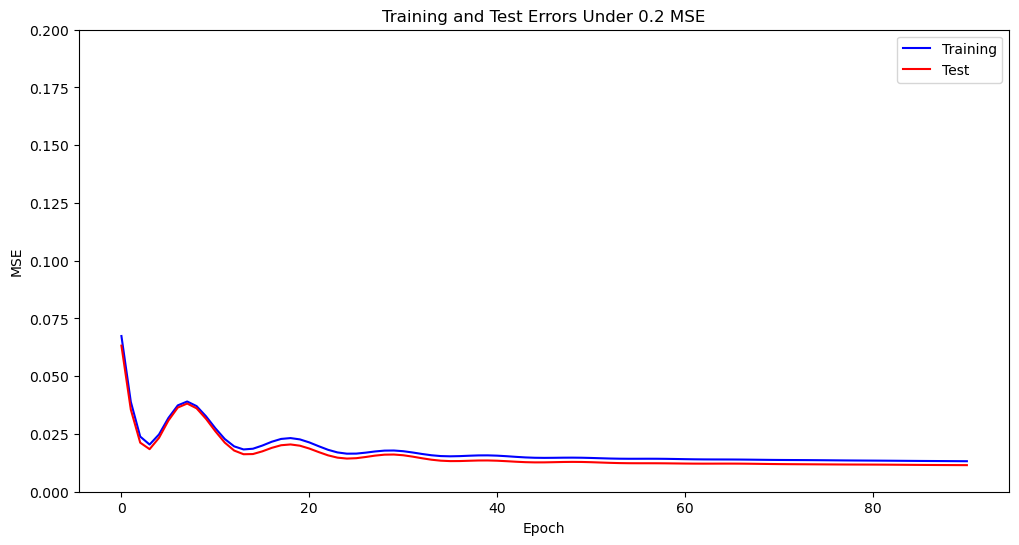

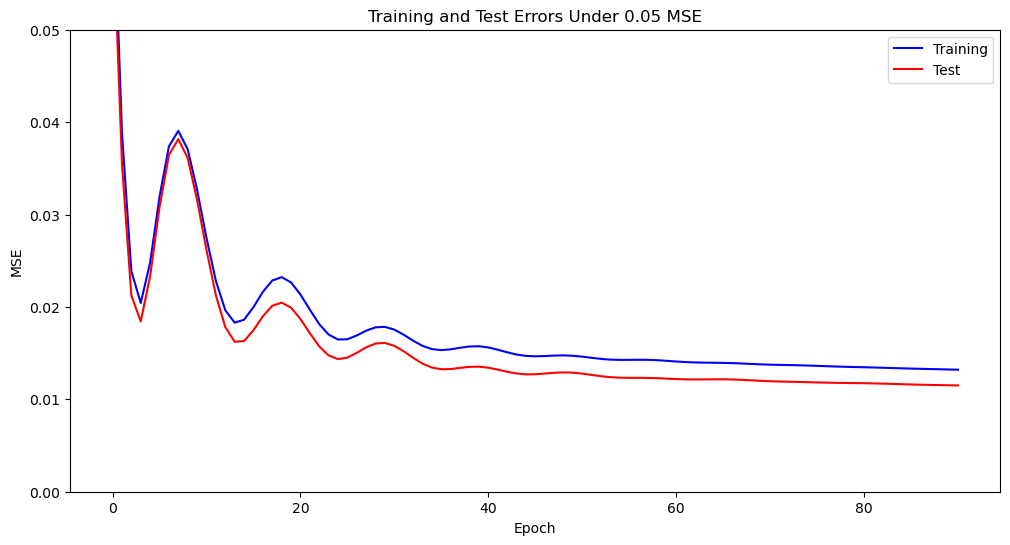

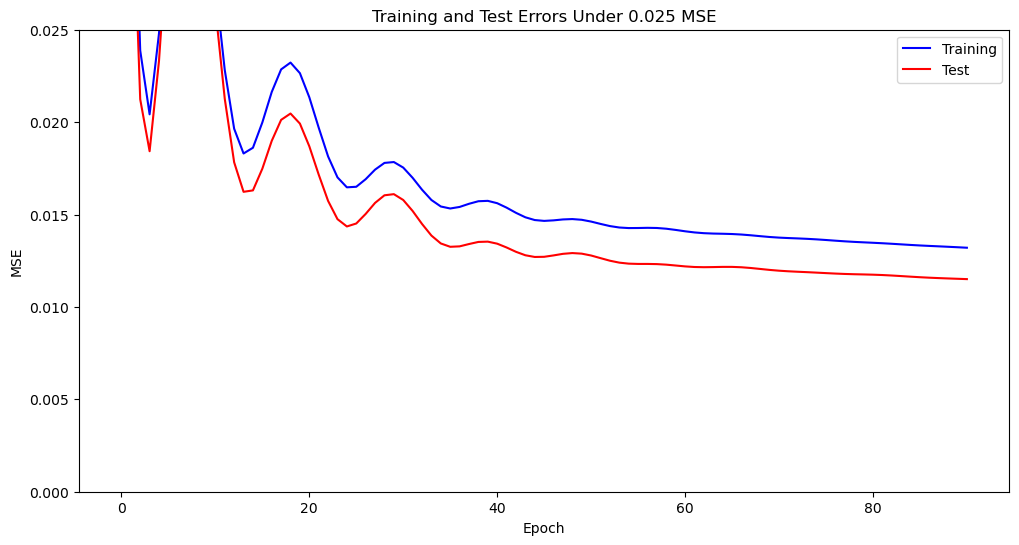

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


deposit_data.loc[:, [variable]+covariates] = scaler.fit_transform(deposit_data.loc[:,[variable]+covariates])


deposit_data=deposit_data.sort_values(by='Z')

x = deposit_data[['X','Y', 'Z'] + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),6)
x = x[:,[0,1,2,3,4,5]]







x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(in_features=6, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(91):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()



# # Define a grid of points for prediction (including X, Y, and Z)
# x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 60)
# y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 6)
# z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
# xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# # Make predictions for the grid
# predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# # Reshape the predictions to match the grid shape
# predictions = predictions.data.numpy().reshape(60, 6, 100)

# pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0]])

# # Determine the minimum and maximum values for the color mapping
# vmin = np.min(pooled_values)
# vmax = np.max(pooled_values)


# fig = go.Figure(data=[
#     go.Scatter3d(
#     x=xyz_grid[:,0],
#     y=xyz_grid[:,1],
#     z=xyz_grid[:,2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=predictions.ravel(),
#         colorscale='BrBG_r',  # Adjust the color scale
#         colorbar=dict(title=mineral),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Preds',
#     text = ["Density: {}".format(x) for x in predictions.ravel() ]
# )])


# # Add a scatter plot for data points
# fig.add_trace(go.Scatter3d(
#     x=x.data.numpy()[:, 0],
#     y=x.data.numpy()[:, 1],
#     z=x.data.numpy()[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=y.data.numpy().ravel(),
#         colorscale='BrBG_r',  # Adjust the color scale
#         colorbar=dict(title=mineral),
#         opacity=0.7,
#         cmax=vmax,
#         cmin=vmin,
#     ),
#     name='Test set',
#     text = ["Density: {}".format(x) for x in y.data.numpy().ravel()]

# ))




# fig.update_layout(
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z',
#         aspectmode='data',
#     ),
# )
# fig.write_html('tmp.html', auto_open=True)
# #fig.show()




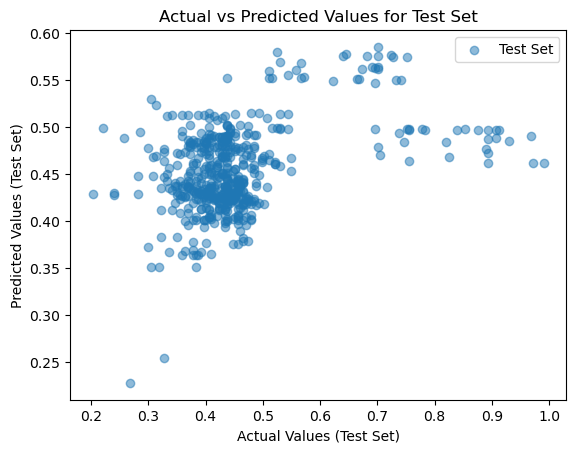

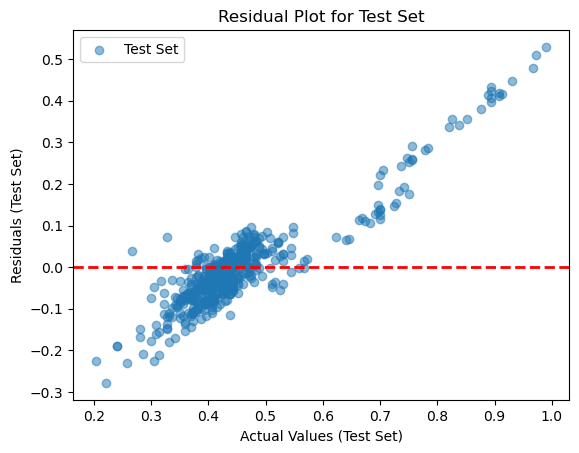

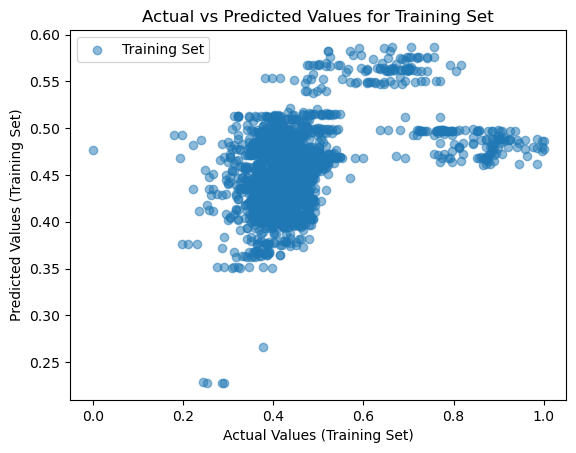

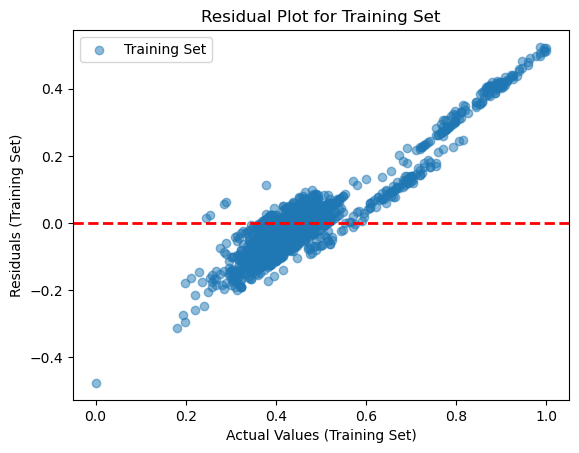

Metrics for Test set:
  MSE: 0.0115
  RMSE: 0.1073
  MAE: 0.0684
  R^2: 0.1786

Metrics for Training set:
  MSE: 0.0132
  RMSE: 0.1149
  MAE: 0.0721
  R^2: 0.1831



In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")

